# Named Entity Recognition with Bi-LSTM

https://github.com/subhasisj/python-projects/blob/master/Machine_Learning_Projects/NLP/Text_classification_Glove_LSTM/Multiclass_text_classification.ipynb

https://www.kaggle.com/alouiamine/ner-using-bidirectional-lstm

https://www.kaggle.com/namanj27/bi-lstm-for-ner-with-liveplotloss

https://www.kaggle.com/abubakaryagob/named-entity-recognition-using-deep-learning

https://www.kaggle.com/tunguz/tensorflow-hub-sentence-embeddings/comments

https://www.kaggle.com/dimitreoliveira/google-quest-eda-and-use-baseline

https://www.kaggle.com/tunguz/tensorflow-hub-sentence-embeddings

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('../Data/ner_dataset.csv',encoding='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [7]:
data.drop(columns=['POS'],inplace=True)

In [8]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   Tag         1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [10]:
data = data.fillna(method='ffill')

In [11]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [21]:
print("unique words; ",data["Word"].nunique())
print("unique tags; ",data["Tag"].nunique())

unique words;  35178
unique tags;  17


In [46]:
from collections import Counter

tag_counts = Counter(data['Tag'])

In [47]:
list(tag_counts)

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

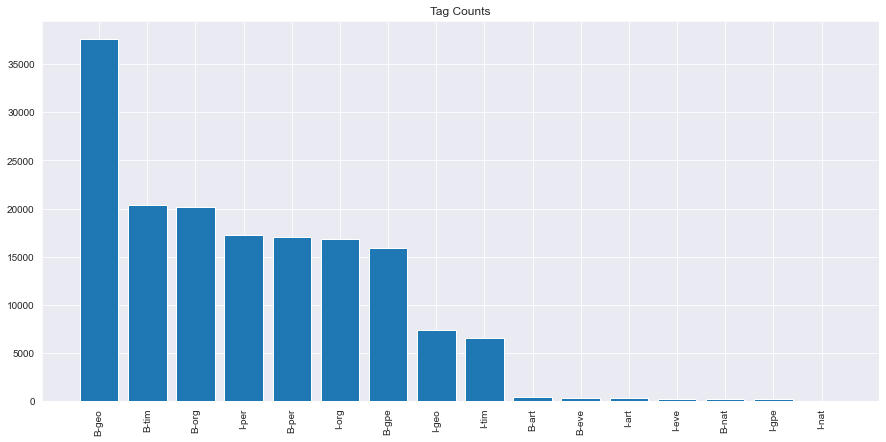

In [49]:
tag_counts = tag_counts.most_common()
tag_counts.pop(0)

plt.figure(figsize=(15,7))
plt.title('Tag Counts')
plt.xticks(rotation='90')
plt.bar(*zip(*tag_counts))
plt.show()

In [50]:
class sentence_getter():
    def __init__(self,data):
        agg_function = lambda s:[(w,t) for w,t in zip(s['Word'].values.tolist(),
                                                      s['Tag'].values.tolist())]
        self.grouped_data = data.groupby('Sentence #').apply(agg_function)
        self.sentences = [s for s in self.grouped_data]

In [52]:
getter = sentence_getter(data)
sentences = getter.sentences
sentences[2]

[('Helicopter', 'O'),
 ('gunships', 'O'),
 ('Saturday', 'B-tim'),
 ('pounded', 'O'),
 ('militant', 'O'),
 ('hideouts', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Orakzai', 'B-geo'),
 ('tribal', 'O'),
 ('region', 'O'),
 (',', 'O'),
 ('where', 'O'),
 ('many', 'O'),
 ('Taliban', 'B-org'),
 ('militants', 'O'),
 ('are', 'O'),
 ('believed', 'O'),
 ('to', 'O'),
 ('have', 'O'),
 ('fled', 'O'),
 ('to', 'O'),
 ('avoid', 'O'),
 ('an', 'O'),
 ('earlier', 'O'),
 ('military', 'O'),
 ('offensive', 'O'),
 ('in', 'O'),
 ('nearby', 'O'),
 ('South', 'B-geo'),
 ('Waziristan', 'I-geo'),
 ('.', 'O')]

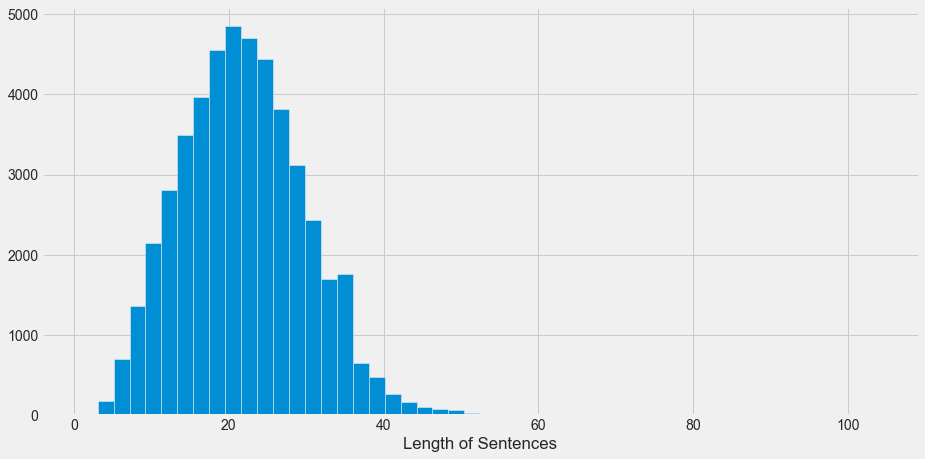

In [53]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

Most of the words are around 20 words. Longest word is around 50 words. We can use this as padding length.

In [70]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=30000,oov_token= '<OOV>',lower=False)
tokenizer.fit_on_texts(data.Word)
word_index = tokenizer.word_index

In [71]:
print(f'Vocabulary size:{len(word_index)}')

Vocabulary size:31303


In [72]:
dict(list(word_index.items())[:15])

{'<OOV>': 1,
 'the': 2,
 'in': 3,
 'of': 4,
 'to': 5,
 'a': 6,
 'and': 7,
 'The': 8,
 "'s": 9,
 'for': 10,
 'has': 11,
 'is': 12,
 'on': 13,
 'that': 14,
 'have': 15}

In [73]:
tags = list(set(data["Tag"].values))
tag_index = {t:i+1 for i,t in enumerate(tags)}
tag_index

{'I-geo': 1,
 'B-gpe': 2,
 'O': 3,
 'B-art': 4,
 'B-org': 5,
 'I-eve': 6,
 'B-per': 7,
 'B-nat': 8,
 'I-nat': 9,
 'I-tim': 10,
 'B-geo': 11,
 'B-eve': 12,
 'B-tim': 13,
 'I-gpe': 14,
 'I-art': 15,
 'I-org': 16,
 'I-per': 17}

In [74]:
word_index['Thousands']

1152

In [75]:
X = [[word_index[w[0]] for w in s] for s in sentence]

KeyError: '.'